## Function Definitions

In [1]:
from pathlib import Path
import sys
sys.path.insert(1, str(Path.cwd().parent))
from tensor_hero.model import Transformer, ColabLazyDataset
import torch
from torch import nn
from torch import optim
from datetime import datetime
import os
import json
import pickle

def __load_model(model_directory):
    '''
    Loads model and param dict from model_directory. useful for continuing training
    Helper function for initialize_params()
    
    ~~~~ ARGUMENTS ~~~~
    - model_directory (Path): Folder containing model weights and params
        - probably ./model/saved_models/<model name>
    
    ~~~~ RETURNS ~~~~
    - dict: params loaded from model directory
    '''
    with open(str(model_directory / 'params.pkl'), 'rb') as f:
        params = pickle.load(f)
    f.close()

    return params

def initialize_params(params):
    '''
    Takes the original params and modifies them to match the current training objective.
        - Will load params from model directory if desired
        - Initializes new params for training a new model
        - Asks for user input regarding descriptions of new models

    ~~~~ ARGUMENTS ~~~~
    - params (dict): Dictionary containing relevant model information. See definition in main() for more information.

    ~~~~ RAISES ~~~~
    - SystemExit: If the experiment is to be aborted.

    ~~~~ RETURNS ~~~~
    - dict: model and training parameters
    '''
    # Ask user whether they will load a pretrained model to continue training or initialize a new model
    response = str(input('Load from pretrained model? (y/n): ')).lower()
    while response not in ['y', 'n']:
        response = str(input('invalid input\nAre the parameters correct (y/n)?: ')).lower()
        
    if response == 'y':  # If loading from pretrained model, load its weights from its directory
        response = str(input('Enter name of model to load: '))  # This will be the name of the directory under ./model/saved_models
        while not os.path.isdir(Path.cwd() / 'model' / 'saved_models' / response):
            print('Error: {} is not a valid directory'.format(response))
            response = str(input('Enter name of model to load: '))
        model_directory = Path.cwd() / 'model' / 'saved_models' / response
        params = __load_model(model_directory)
        params['LOAD'] = True

    else:  # If initializing new model, create a new directory for it
        while os.path.isdir(Path.cwd() / 'model' / 'saved_models' / params['model_name']):
            new_name = input('Directory already exists.\nEnter new model name: ')
            params['model_name'] = str(new_name)
        os.mkdir(Path.cwd() / 'saved_models' / params['model_name'])
        params['LOAD'] = False

    params['model_file_name'] = params['model_name'] + '.pt'  # Holds weights of model
    params['model_outfile'] = str(Path.cwd() / 'model' / 'saved_models' / params['model_name'] / params['model_file_name'])  # model directory

    # Validate parameters
    print(json.dumps(params, indent=4))
    response = str(input('Are the parameters correct (y/n)?: ')).lower()
    while response not in ['y', 'n']:
        response = str(input('invalid input\nAre the parameters correct (y/n)?: ')).lower()
    if response == 'n':
        raise SystemExit(0)

    # Gather description of experiment from user
    if not 'experiment_description' in params.keys():
        experiment_description = input('Enter experiment description: ')
        params['experiment_description'] = experiment_description

    # Save parameters
    with open(str(Path.cwd() / 'saved_models' / params['model_name'] / 'params.pkl'), 'wb') as f:
        pickle.dump(params, f)
    f.close()
    
    print('parameters saved\n')
    
    return params

def initialize_model(params, device):
    '''
    Takes params and the device (CUDA or CPU) and initializes a transformer model, as defined in ./tensor_hero/model.py
    
    ~~~~ ARGUMENTS ~~~~
    - params (dict): Model and training parameters. Should be the output from initialize_params()
    - device (str): "CUDA" or "CPU"
    
    ~~~~ RETURNS ~~~~
        PyTorch model: Transformer model initialized with params and sent to device. Defined in ./tensor_hero/model.py
    '''
    model = Transformer(
            embedding_size = params['embedding_size'],
            trg_vocab_size = params['trg_vocab_size'],
            num_heads = params['num_heads'],
            num_encoder_layers = params['num_encoder_layers'],
            num_decoder_layers = params['num_decoder_layers'],
            forward_expansion = params['embedding_size']*params['forward_expansion'],
            dropout = params['dropout'],
            max_len = params['max_src_len'],
            device = device,
        ).to(device)

    return model


## Model and Training Initialization

In [2]:
params = {
    'training_data' : 'train separated',     # CHANGEME (these parameters must be changed each experiment)
    'model_name' : 'loss_function_test2',     # CHANGEME
    'optimizer' : 'Adam',                    # CHANGEME (maybe not this one, but you do have to fill it in manually)
    'train_path' : Path.cwd().parent / 'Training_Data' / 'training_ready' / 'train',

    'num_epochs' : 500,
    'batch_size' : 12,
    'shuffle' : True,
    'num_workers' : 4,
    'drop_last' : True,
    'last_global_step' : 0,

    'max_trg_len' : 500, # NOTE: max_trg_len <= max_src_len otherwise side asset error is triggered
    'max_src_len' : 500,
    'trg_vocab_size' : 435,
    'pad_idx' : 434,
    'embedding_size' : 512,

    'lr' : 1e-4,
    'num_heads' : 8,
    'num_encoder_layers' : 2,
    'num_decoder_layers' : 2,
    'dropout' : 0.1,
    'forward_expansion' : 4,

    'date' : datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
}
# ---------------------------------------------------------------------------- #
#                                  DATALOADER                                  #
# ---------------------------------------------------------------------------- #

dl_params = {
    'batch_size' : params['batch_size'],
    'shuffle' : params['shuffle'],
    'num_workers' : params['num_workers'],
    'drop_last' : params['drop_last'],
}

# Define data loaders
train_data = ColabLazyDataset(Path(params['train_path']), params['max_src_len'], params['max_trg_len'], params['pad_idx'])
train_loader = torch.utils.data.DataLoader(train_data, **dl_params)

# ---------------------------------------------------------------------------- #
#                              TRAINING PARAMETERS                             #
# ---------------------------------------------------------------------------- #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training hyperparameters
learning_rate = params['lr']
num_epochs = params['num_epochs']

model = initialize_model(params, device) 

# torch.save(model.state_dict(), 'model.pt')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# criterion = nn.CrossEntropyLoss() # Multi-class loss, when you have a many class prediction problem
criterion = nn.CrossEntropyLoss(ignore_index=params['pad_idx'])

100%|██████████| 2008/2008 [00:00<00:00, 3669.76it/s]


0 datapoints removed due to exceeding maximum length


## Training Loop

Let's use this loop to parse out the shape of all the inputs and the outputs

In [3]:
model.train() # Put model in training mode, so that it knows it's parameters should be updated
for batch_idx, batch in enumerate(train_loader):
    # Batches come through as a tuple defined in the return statement __getitem__ in the Dataset
    spec, notes = batch[0].to(device), batch[1].to(device)
    
    print('MODEL INPUTS  (the notes are input for training purposes)\n~~~~~~~~~~~~~~~~')
    print(f'spec shape: {spec.shape}')
    print(f'notes shape: {notes.shape}')

    # forward prop
    output = model(spec, notes[..., :-1])           # Don't pass the last element into the decoder, want it to be predicted

    print('\nMODEL OUTPUT\n~~~~~~~~~~~~~~~')
    print(f'output shape: {output.shape}')
    # output = output.reshape(-1, output.shape[2])  # Reshape the output for use by criterion
    notes = notes[..., 1:] # .reshape(-1)           # Same for the notes
    print(f'notes shape: {notes.shape}')
    optimizer.zero_grad()                           # Zero out the gradient so it doesn't accumulate

    loss = criterion(output.permute(0,2,1), notes)  # Calculate loss, this is output vs ground truth
    
    print('\nLOSS FUNCTION INPUT SHAPE\n~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f'Ground Truth Notes shape: {notes.shape}')
    print(f'Candidate Notes shape: {output.permute(0,2,1).shape}')
    print('\nIt looks like the ground truth is input as notes only and the candidate is a series of probabilities.')
    print('In order to format the candidate like the ground truth, we need to take the argmax over the 2nd dimension')
    print(f'Here is the shape when argmaxed over the second dimension: torch.argmax(output.permute(0,2,1),dim=1).shape = {torch.argmax(output.permute(0,2,1),dim=1).shape}')

    print('\nZooming in on the loss function inputs:')
    print('Let\'s ignore the batch dimension and print just a single ground truth and candidate:')
    print('~~~~~~~~~~~~~~~~~~~~~~~')
    print(f'Single Ground Truth Notes: {notes[0]}')
    print(f'\nSingle Candidate Notes: {output.permute(0,2,1)[0]}')
    print(f'\nArgmax of Single Candidate Notes: {torch.argmax(output.permute(0,2,1), dim=1)[0]}')
    print('\nWow this model is stupid right now, makes sense it hasn\'nt been trained at all yet.')
    
    print(f'\nThis is output by loss(): {loss}')
    
    loss.backward()     # Compute loss for every node in the computation graph

    # This line to avoid the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    optimizer.step()    # Update model parameters
    params['last_global_step'] += 1
    break


MODEL INPUTS  (the notes are input for training purposes)
~~~~~~~~~~~~~~~~
spec shape: torch.Size([12, 512, 500])
notes shape: torch.Size([12, 500])

MODEL OUTPUT
~~~~~~~~~~~~~~~
output shape: torch.Size([12, 499, 435])
notes shape: torch.Size([12, 499])

LOSS FUNCTION INPUT SHAPE
~~~~~~~~~~~~~~~~~~~~~~~~~
Ground Truth Notes shape: torch.Size([12, 499])
Candidate Notes shape: torch.Size([12, 435, 499])

It looks like the ground truth is input as notes only and the candidate is a series of probabilities.
In order to format the candidate like the ground truth, we need to take the argmax over the 2nd dimension
Here is the shape when argmaxed over the second dimension: torch.argmax(output.permute(0,2,1),dim=1).shape = torch.Size([12, 499])

Zooming in on the loss function inputs:
Let's ignore the batch dimension and print just a single ground truth and candidate:
~~~~~~~~~~~~~~~~~~~~~~~
Single Ground Truth Notes: tensor([ 41,   0,  71,   2, 101,   0, 131,   2, 161,   0, 191,   2, 221,   1,

In [5]:
output.shape

torch.Size([12, 499, 435])

In [ ]:

def m1_tensor_to_note_array(output, PRINT=False):
    '''
    m1 tensors are returned from model 1.
    not currently designed to handle batches.

    ~~~~ ARGUMENTS ~~~~
    output : torch tensor
    -   output from model 1, e.g. tensor([])

    ~~~~ RETURNS ~~~~
    notes_array : numpy array
    -   shape = (<song length in seconds * 100>,)
    -   indices represent time in 10ms bins, values represent notes
    '''
    output = torch.argmax(output, dim=1)
    output = output.detach().cpu().numpy()
    # Remove padding, <sos>, <pad>
    output = np.delete(output, np.where(output == 432)) # <sos>
    '''
    # NOTE: The padding and EOS are removed in the inference loop now
    # May depracate soon

    output = np.delete(output, np.where(output == 434)) # <pad>
    # Find <eos> and only consider output before it
    eos_idx = np.where(output == 433)[0][0]             # <eos>
    print('END OF SEQUENCE INDEX: {}'.format(eos_idx))
    output = output[:eos_idx]
    '''

    # Detect the properly formatted pairs of output, i.e. (time, note)
    note_vals = list(range(32))     # Values of output array corresponding to notes
    time_vals = list(range(32,432)) # Corresponding to times

    # Loop through the array two elements at a time
    pairs = []
    for i in range(output.shape[0]-1):
        pair = (output[i], output[i+1])
        if pair[0] in time_vals and pair[1] in note_vals:
            pairs.append(pair)  # Append if pair follows (time, note) pattern

    # Create notes array
    notes_array = np.zeros(400)
    for pair in pairs:
        notes_array[pair[0]-32] = pair[1]
    
    if PRINT:
        print(notes_array)


    return notes_array


In [27]:
import numpy as np
# print(torch.argmax(raw_output, dim=2))

def single_prediction_to_notes_array(prediction):
    '''
    Takes a single prediction from the transformer and translates it to a notes array
    of length 400.

    ~~~~ ARGUMENTS ~~~~
    -   prediction (Numpy Array, shape=(<max_trg_len>,)):
            -   Prediction from the transformer, should be a single list of max indices
                from transformer prediction. Expected to be in (time, note, time, note, etc.)
                format.
        
    ~~~~ RETURNS ~~~~
    -   notes_array (Numpy Array, shape = (400,)):
            -   The prediction translated into a 4 second simplified notes array
    '''
    note_vals = list(range(32))     # Values of output array corresponding to notes
    time_vals = list(range(32,432)) # Corresponding to times

    # Loop through the array two elements at a time
    pairs = []
    for i in range(prediction.shape[0]-1):
        pair = (prediction[i], prediction[i+1]) # Take predicted notes as couples
        if pair[0] in time_vals and pair[1] in note_vals:
            pairs.append(pair)  # Append if pair follows (time, note) pattern

    # Create notes array
    notes_array = np.zeros(400)
    for pair in pairs:
        notes_array[pair[0]-32] = pair[1]
    return notes_array

def transformer_output_to_notes_array(output, PROBABILITIES=True):
    '''
    Takes a batch of output or input to the transformer and converts it to notes arrays.
    Converts the "model 1 data" as described in ./Documentation/'format of model 1 data.txt'
    Returns a matrix of notes arrays, the 0th dimension corresponding to the batch dimension
    of output

    ~~~~ ARGUMENTS ~~~~
    -   output (Torch Tensor, shape=[<batch_size>, <max_trg_len-1>, 435]):
            - Can either be the raw output from the transformer or the ground truth input
            - The difference between GT input and output is that GT input does not need to be
            collapsed along the probability dimension. If GT input, set PROBABILITES=True
    
    -   PROBABILITIES (bool, optional):
            - True if raw transformer output, False if ground truth transformer input 
            - If True, assumes that output has a probability dimension

    ~~~~ RETURNS ~~~~
    -   notes_arrays (Numpy Array, shape = (<batch_size>, 400)):
            - A batch of notes arrays corresponding to the input batch of transformer output
    '''
    output = output.detach().cpu().numpy()   # detach from computation graph, convert to numpy
    if PROBABILITIES:   # If the output has an extra dimension for probabilities
        output = np.argmax(output, axis=-1)      # go from probabilities to index predictions
    
    # Initialize matrix of notes arrays
    notes_arrays = np.empty(shape=(output.shape[0], 400))
    for idx in range(output.shape[0]):      # Each element of the batch gets computed individually
        prediction = np.delete(output[idx], np.where(output[idx] >= 432))  # delete <sos>, <eos>, <pad>
        notes_arrays[idx] = single_prediction_to_notes_array(prediction)

    return  notes_arrays
    
    
notes_arrays_candidate = transformer_output_to_notes_array(output)
notes_arrays_ground_truth = transformer_output_to_notes_array(notes, PROBABILITIES=False)
print(notes_arrays_candidate.shape)
print(notes_arrays_ground_truth.shape)

(12, 400)
(12, 400)


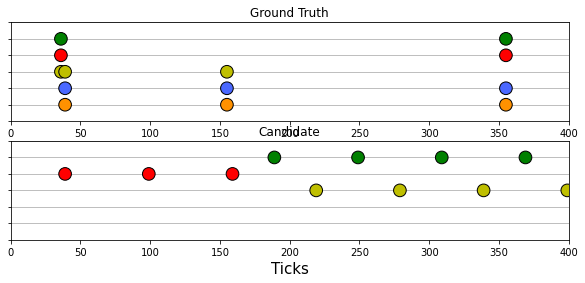

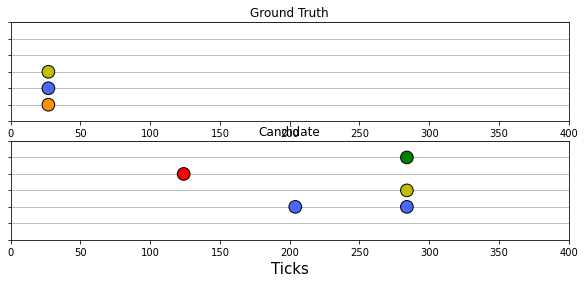

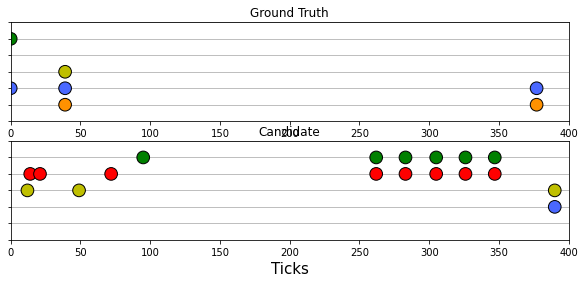

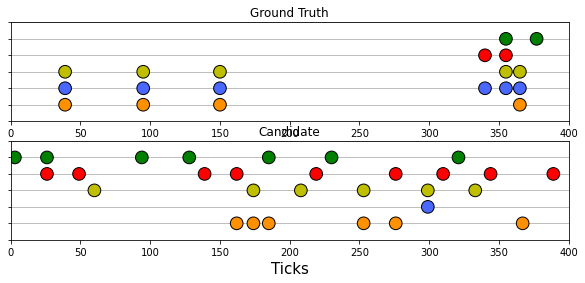

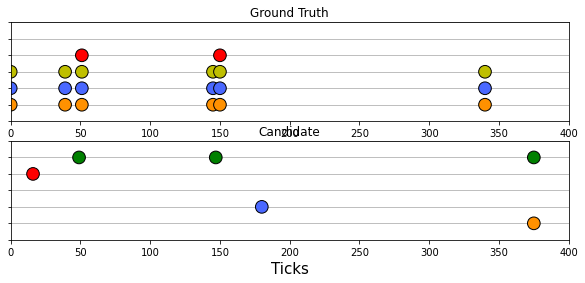

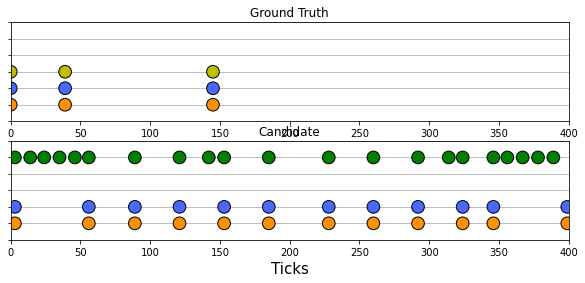

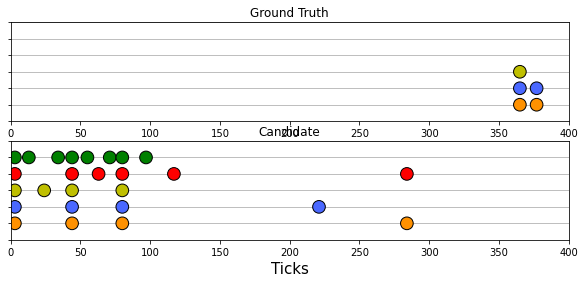

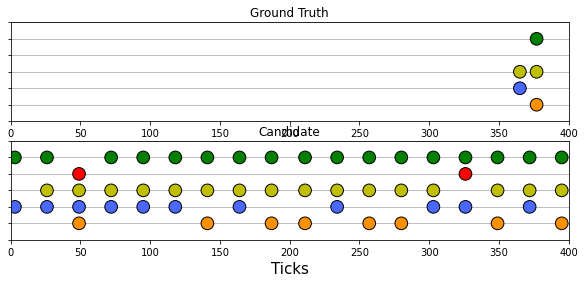

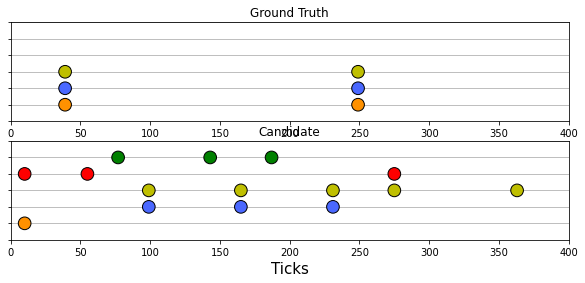

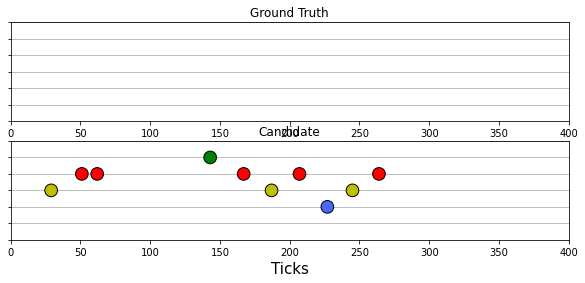

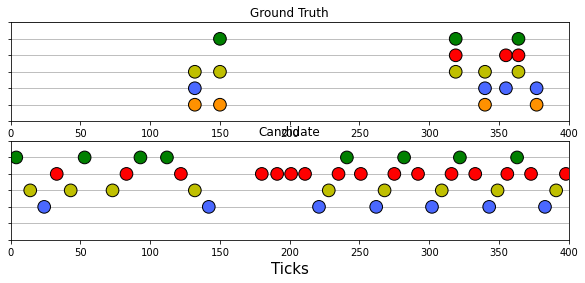

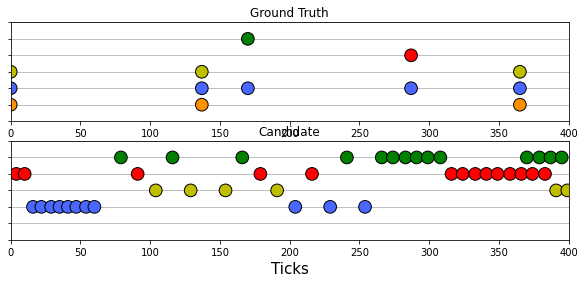

In [29]:
from tensor_hero.visualization import plot_chart

for i in range(notes_arrays_candidate.shape[0]):
    _ = plot_chart(notes_arrays_candidate[i], notes_arrays_ground_truth[i])
